<a href="https://colab.research.google.com/github/adityakalkeri1/Projects/blob/Time-series/Uber_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uber Time series *dataset*

### Installing pmdarima

In [316]:
!pip install pmdarima
!pip install geopandas

### Importing Necessary dependencies

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [318]:
#Setting seaborn style
sns.set_style('dark')

#setting seaborn palette
sns.set_palette('brg_r')               #Try dark_r, brg_r, bwr, bwr_r,cool,cool_r, plasma, viridis, viridis_r, 

In [319]:
%matplotlib inline

### Importing the dataset

In [320]:
from google.colab import drive

drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [321]:
#There are 6 csv file each having ride booking data from April till September
df1 = pd.read_csv('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/uber-raw-data-apr14.csv'  )
df2 = pd.read_csv('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/uber-raw-data-may14.csv'  )
df3 = pd.read_csv('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/uber-raw-data-jun14.csv'  )
df4 = pd.read_csv('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/uber-raw-data-jul14.csv'  )
df5 = pd.read_csv('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/uber-raw-data-aug14.csv'  )
df6 = pd.read_csv('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/uber-raw-data-sep14.csv'  )

In [322]:
#Making a single dataset
df = pd.concat([df1, df2, df3, df4, df5, df6])                        
#Converting Dat/Time column into pandas datetime format and Setting as index
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace = True)

In [323]:
df.isnull().sum()

Lat     0
Lon     0
Base    0
dtype: int64

In [324]:
df.shape

(4534327, 3)

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4534327 entries, 2014-04-01 00:11:00 to 2014-09-30 22:58:00
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Lat     float64
 1   Lon     float64
 2   Base    object 
dtypes: float64(2), object(1)
memory usage: 138.4+ MB


In [326]:
print('Map according to Latitude and Longitude')
print('Longitude - Right limit: ', df['Lon'].max())
print('Longitude - Left limit: ', df['Lon'].min())
print('Latitude upper limit: ', df['Lat'].max())
print('Latitude - lower limit: ', df['Lat'].min())

Map according to Latitude and Longitude
Longitude - Right limit:  -72.0666
Longitude - Left limit:  -74.929
Latitude upper limit:  42.1166
Latitude - lower limit:  39.6569


If we put the above coordinates in Open Street Maps, we get the below New York city region

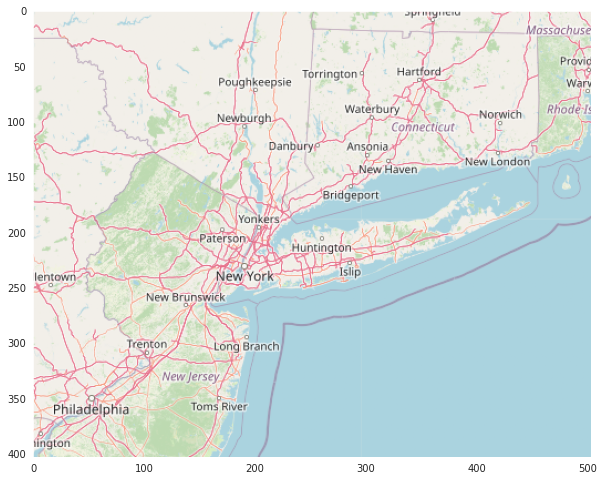

In [327]:
plt.figure(figsize = (10,10))
image = plt.imread('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/map(1).png')
plt.imshow(image)


The data is time-series, with each row representing someone booking the ride, the location where the uber cab was called and the Base (Not sure of the meaning of this)

The Dataset starts from 1st April 2014 and ends on 30th Sept 2014

There are total 4.53 million rows,each indicating one booking

### EDA

First we will explore the number of rides booked and plot the no of rides booked hourly, daily, weekly, monthly

Text(0.5, 1.0, 'Booked Rides by the hour (all months combined)')

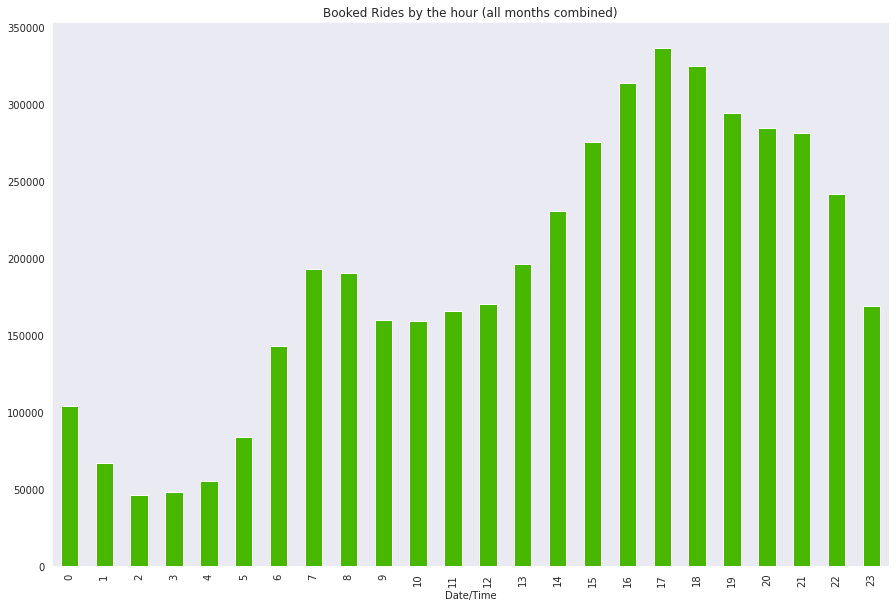

In [328]:
#Plotting Hourly data
df.groupby(df.index.hour)['Base'].count().plot.bar(figsize = (15,10))
plt.title('Booked Rides by the hour (all months combined)')

The ride bookings are low from 12am-5am, with lowest at 2am.

The bookings pick up in the morning from 6 am, and reaches the peak at around 17:00 or 5pm (when everyone is leaving the office), starts decreasing again from 21:00 or 9pm

Text(0.5, 1.0, 'Booked Rides by the days (all months combined)')

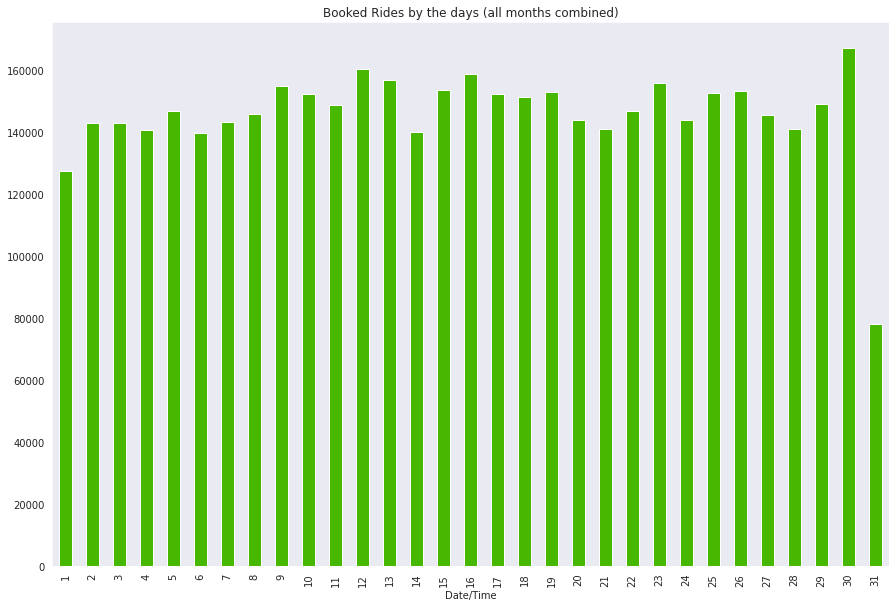

In [329]:
#Plotting daily ride bookings
df.groupby(df.index.day)['Base'].count().plot.bar(figsize = (15,10))
plt.title('Booked Rides by the days (all months combined)')

In [330]:
df['weekday'] = df.index.weekday

In [331]:
map_dict = { 0:'Sunday', 1: 'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'}
df['weekday'] = df['weekday'].map(map_dict)

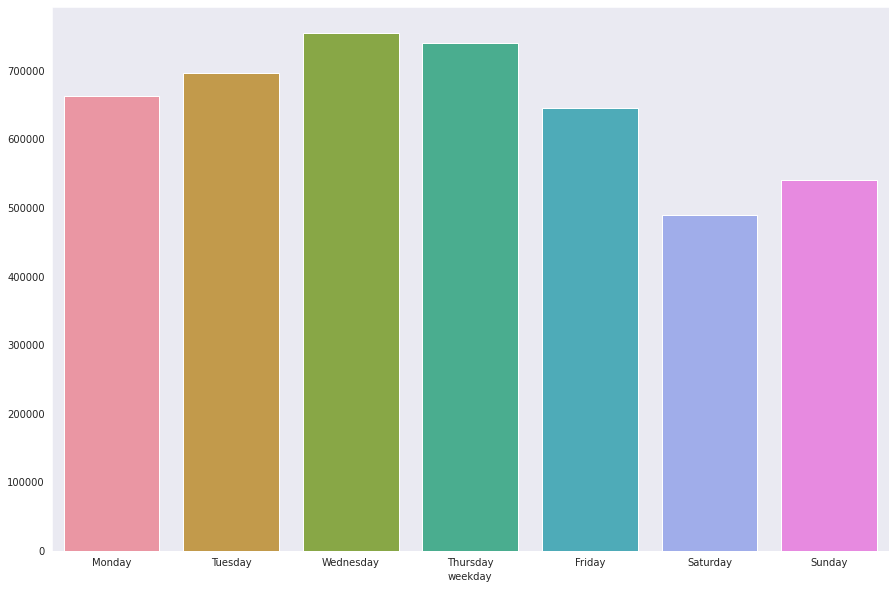

In [332]:
#Plotting Weekly data
plt.figure(figsize=(15,10))
sns.barplot(x = df.groupby('weekday')['weekday'].count().index,
            y = df.groupby('weekday')['weekday'].count().values,
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
            #color = 'green')

Text(0.5, 1.0, 'Booked Rides by the months')

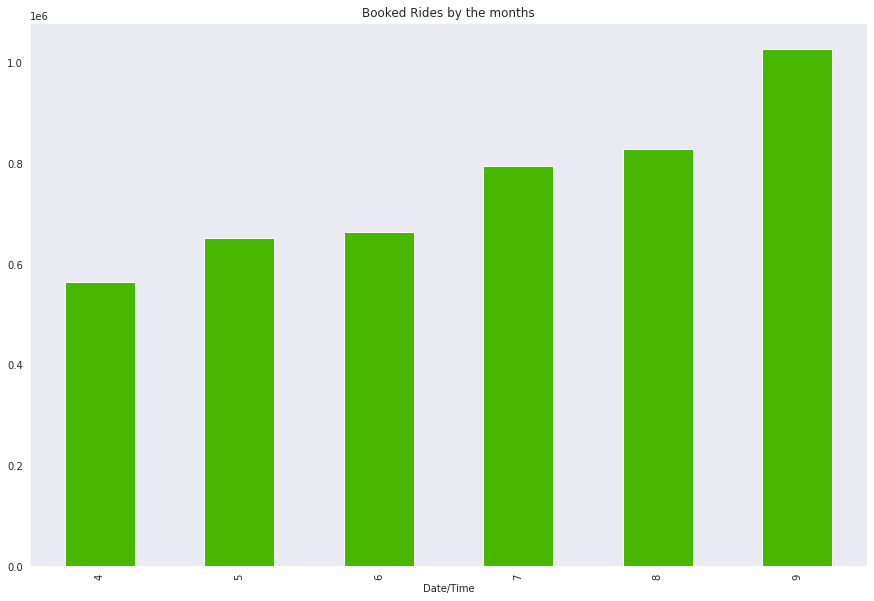

In [333]:
#Now plotting monthly data
df.groupby(df.index.month)['Base'].count().plot.bar(figsize = (15,10))
plt.title('Booked Rides by the months')

Lets draw some time-series data

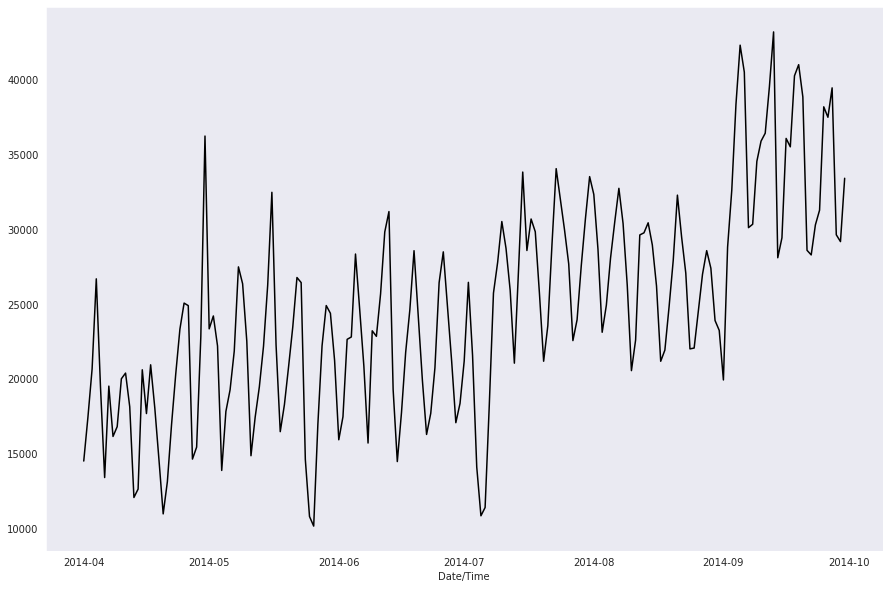

In [334]:
plt.figure(figsize = (15,10))
sns.lineplot(x = df.resample('D')['Base'].count().index, y = df.resample('D')['Base'].count().values, color = 'black')

There is a clear upward trend and seasonality. If we had to guess seasonality frequency, the pattern repeats weekly.

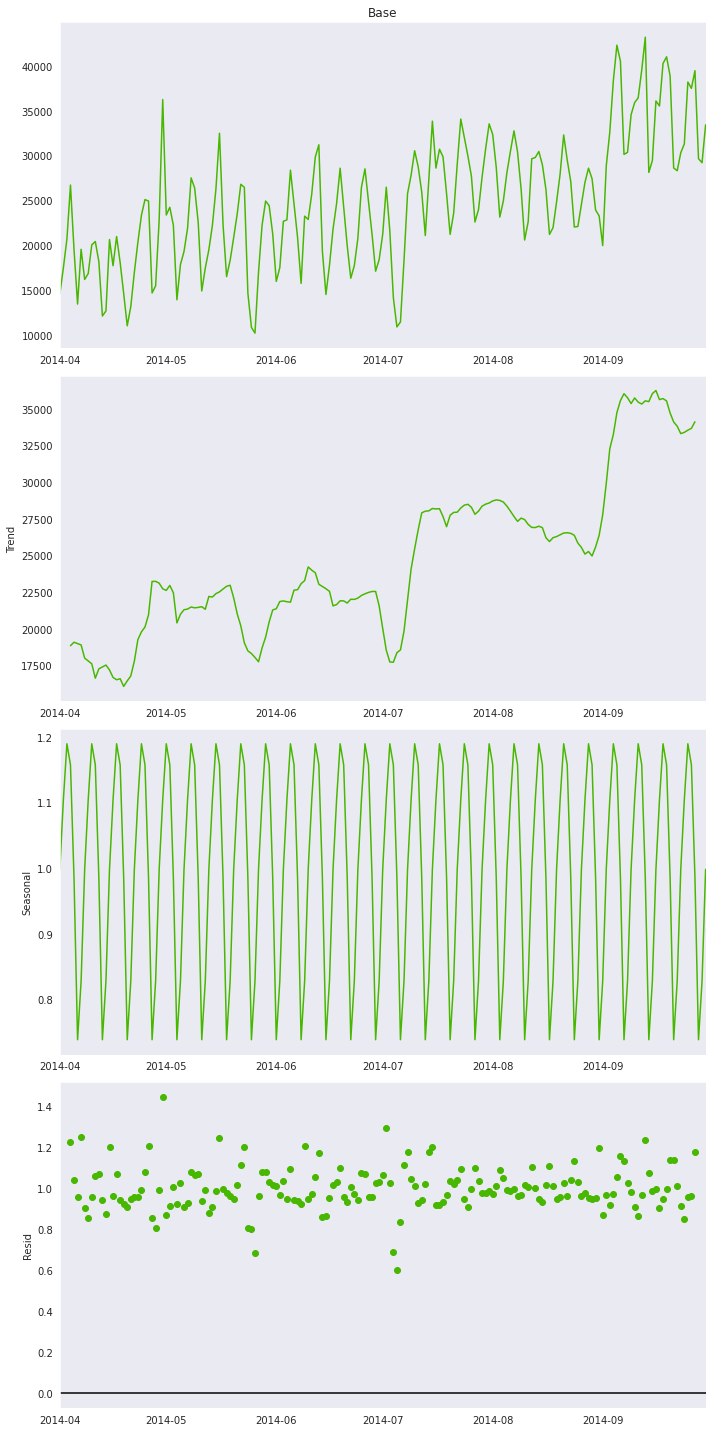

In [335]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib

ets = seasonal_decompose(df.resample('D')['Base'].count(), model = 'multiplicative')

matplotlib.rcParams['figure.figsize'] = 10,20
ets.plot();

Now we will try to model the time-series data, and try to predict the future daily ride bookings

# Modelling

### Step 1 : Finding differencing

In [336]:
#Counducting Dickey Fuller test
#Dickey Fuller test
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(values):
  df_test = adfuller(values)
  df_out = pd.Series(df_test[0:4], index = ['ADF stats', 'p-value', 'no of lags', 'no of observations'])
  print(df_out)

#Differencing function:
def difference(data, interval):
  diff_list = list()
  for i in range(len(data)):
    diff = data.iloc[i] - data.iloc[i-interval]
    diff_list.append(diff)
  return diff_list

Dickey Fuller test is a hypothesis test to check whether the data is stationary or not.

If the data is stationary, then in ARIMA / SARIMA models, there will be no differencing

If the data is not stationary, then we have to find out the number of differencing required for the model

In [337]:
data = df.resample('D')['Base'].count()
dickey_fuller(data.values)

ADF stats              -0.703280
p-value                 0.845898
no of lags             12.000000
no of observations    170.000000
dtype: float64


Since p-value > 0.05, the data is not stationary

In [338]:
diff_1 = difference(data, 1)     #Taking 1 interval
dickey_fuller(diff_1)


ADF stats            -6.140253e+00
p-value               8.003285e-08
no of lags            1.100000e+01
no of observations    1.710000e+02
dtype: float64


Since p-value for this test < 0.05, to make the data stationary, we have to difference the data by 1 position

### Step 2 : Finding AR and MA order

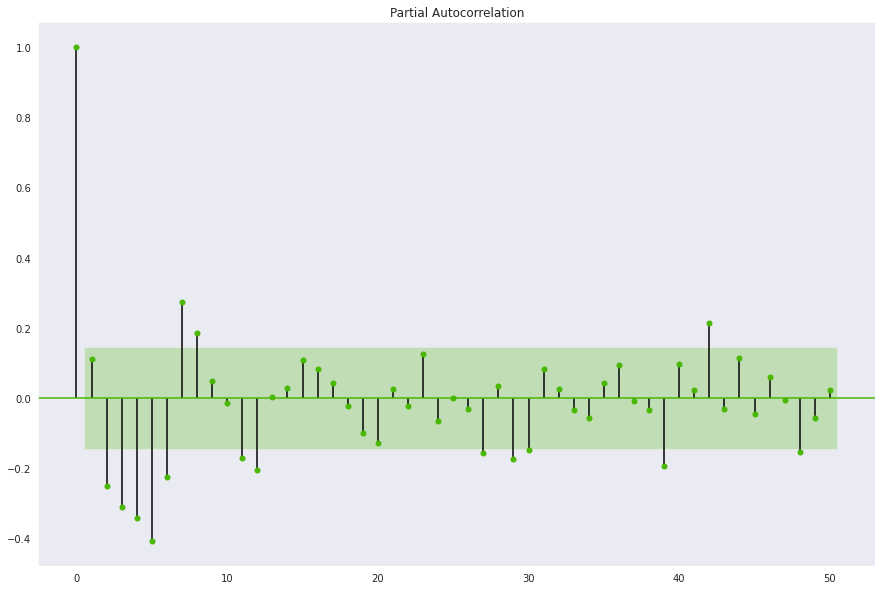

In [339]:
matplotlib.rcParams['figure.figsize'] = 15,10
plot_pacf(diff_1, lags = 50);

In PACF plot, significant drop is noticed at k = 1, so AR(1) model will be used

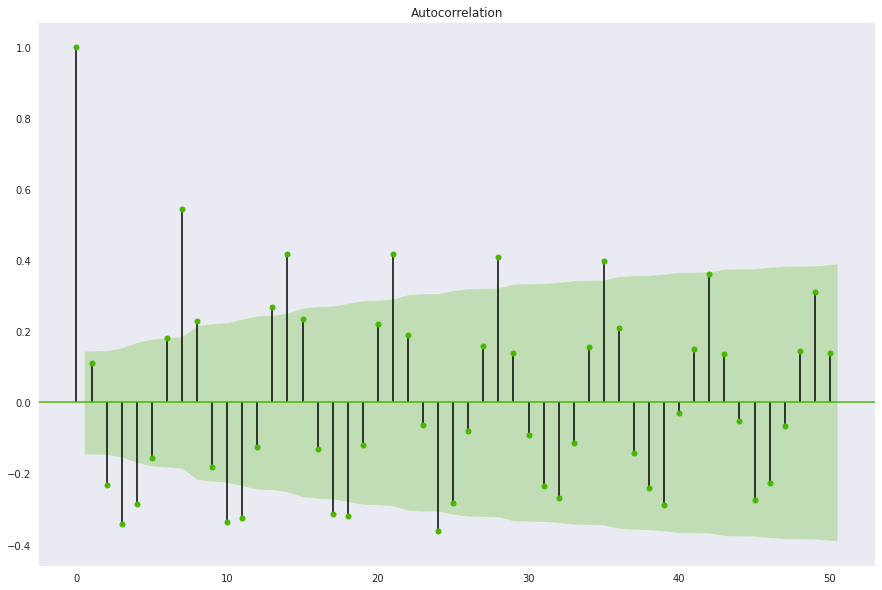

In [340]:
#Plotting acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
matplotlib.rcParams['figure.figsize'] = 15,10
plot_acf(diff_1, lags = 50);

Significant drop after k = 1, so MA term will be 1

So the order of ARIMA model will be (1,1,1). Lets see how the model fits our data

Chosing sept as out test month

In [341]:
train = data.loc[:pd.to_datetime('09-01-2014')]
test = data.loc[pd.to_datetime('09-01-2014'):]

### Step 3: Creating Model

In [342]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order  = (1,1,1), seasonal_order = (1, 1, 1, 7))

results = model.fit()

In [343]:
predict = results.predict(len(train), len(data))

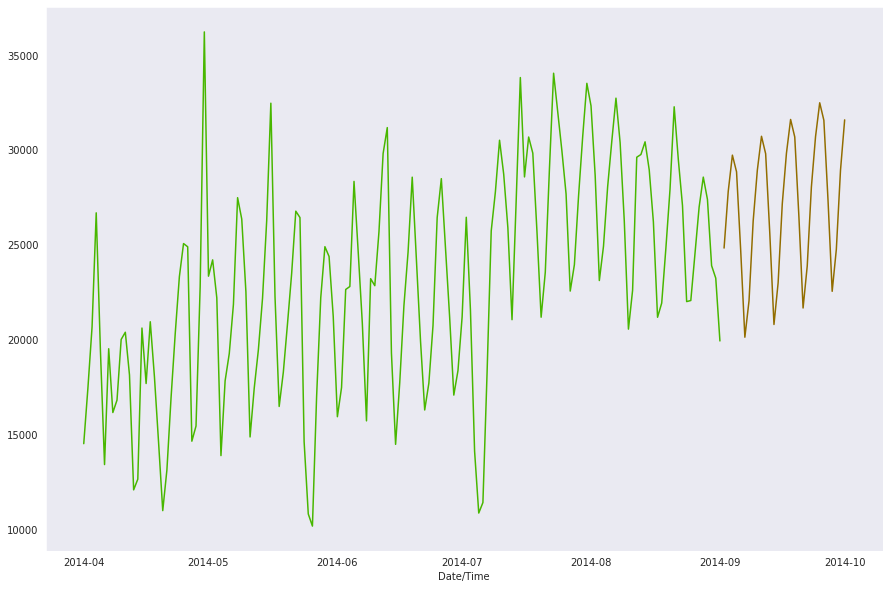

In [344]:
plt.figure()
sns.lineplot(x = train.index, y = train.values)
sns.lineplot(x = predict.index, y = predict.values)

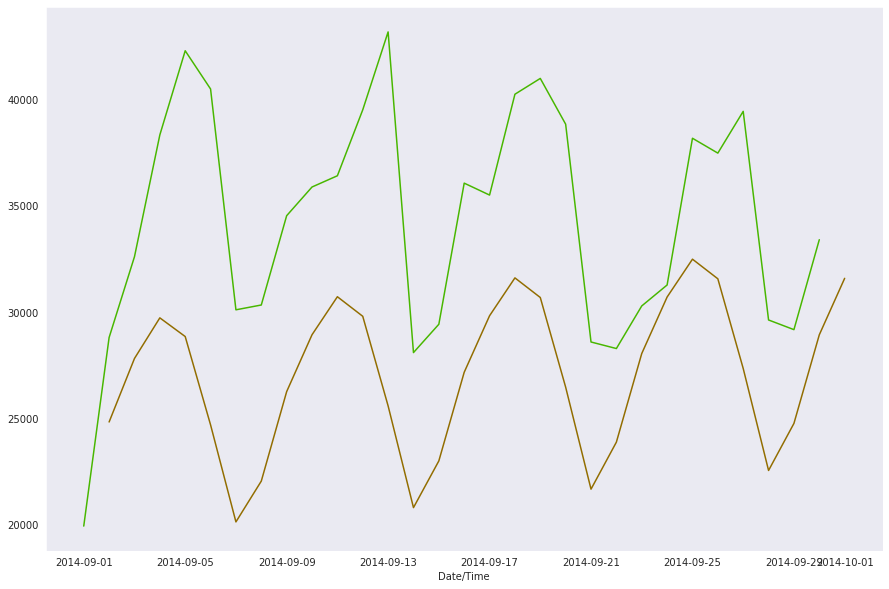

In [345]:
plt.figure()
sns.lineplot(x = test.index, y = test.values)
sns.lineplot(x = predict.index, y = predict.values)

In [346]:
from sklearn.metrics import mean_squared_error
import math
error = math.sqrt(mean_squared_error(test.values, predict.values))

print('RMSE Error for SARIMA model: ', error)

RMSE Error for SARIMA model:  9814.58603366927


In [347]:
from pmdarima import auto_arima

auto_model = auto_arima(train, seasonal=True)

auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  154
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1457.907
Date:                Fri, 07 May 2021   AIC                           2925.815
Time:                        22:34:04   BIC                           2940.967
Sample:                             0   HQIC                          2931.970
                                - 154                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2378      0.019     63.891      0.000       1.200       1.276
ar.L2         -0.9735      0.016    -60.080      0.000      -1.005      -0.942
ma.L1         -1.2988      0.041    -31.340      0.000      -1.380      -1.218
ma.L2          0.9030      0.051     17.765      0.000       0.803       1.003
sigma2      1.027e+07   3.11e-10    3.3e+16      0.000    1.03e+07    1.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.99   Jarque-Bera (JB):                28.61
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+34. Standard errors may be unstable.
"""

In [348]:
auto_model

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [349]:
predict = auto_model.predict(len(test))

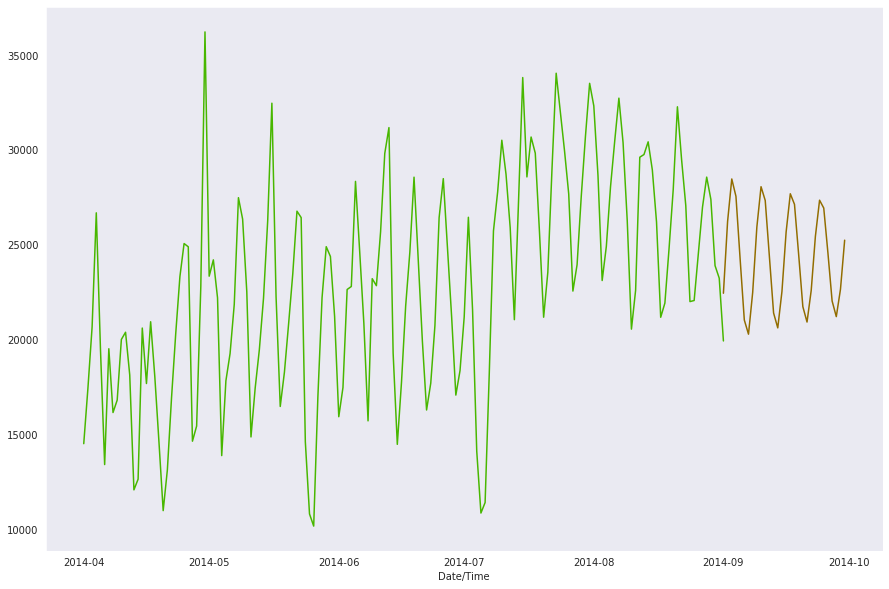

In [350]:
plt.figure()
sns.lineplot(x = train.index, y = train.values)
sns.lineplot(x = test.index, y = predict)

In [351]:
error = math.sqrt(mean_squared_error(test.values, predict))

print('RMSE Error for SARIMA model: ', error)

RMSE Error for SARIMA model:  11317.962465571538


# Plotting map data

In [352]:
#Loading USA shp file
geodf = geopandas.read_file('/content/MyDrive/MyDrive/Datasets/Uber dataset/Uber-dataset/Clipped/NYC_clipped.shp')

In [353]:
#Here we will limit the area to 3 required states
area = geodf[(geodf['NAME_1'] =='New York') | (geodf['NAME_1']== 'New Jersey') | (geodf['NAME_1'] == 'Connecticut')]

In [354]:
#NAME_2 mean county names
area['NAME_2'].unique()

array(['Fairfield', 'Litchfield', 'New Haven', 'Dutchess', 'Putnam',
       'Westchester', 'Hartford', 'Middlesex', 'New London', 'Tolland',
       'Columbia', 'Windham', 'Suffolk', 'Cumberland', 'Gloucester',
       'Salem', 'Rensselaer', 'Atlantic', 'Burlington', 'Camden',
       'Cape May', 'Ocean', 'Bergen', 'Essex', 'Hudson', 'Morris',
       'Passaic', 'Bronx', 'New York', 'Queens', 'Rockland', 'Mercer',
       'Monmouth', 'Union', 'Kings', 'Richmond', 'Hunterdon', 'Somerset',
       'Warren', 'Sussex', 'Orange', 'Albany', 'Greene', 'Montgomery',
       'Saratoga', 'Schenectady', 'Schoharie', 'Allegany', 'Cattaraugus',
       'Livingston', 'Steuben', 'Wyoming', 'Nassau', 'Broome', 'Chenango',
       'Cortland', 'Delaware', 'Otsego', 'Tioga', 'Chautauqua', 'Erie',
       'Cayuga', 'Lake Ontario', 'Onondaga', 'Oswego', 'Seneca',
       'Tompkins', 'Wayne', 'Chemung', 'Schuyler', 'Madison', 'Clinton',
       'Franklin', 'Ulster', 'Sullivan', 'Genesee', 'Niagara', 'Hamilton',
       

In [355]:
#extracting required county area
county = ['Bronx', 'New York', 'Queens', 'Kings','Essex', 'Bergen', 'Hudson', 'Richmond', 'Nassau', 'Westchester','Union', 'Middlesex', 'Passaic', 'Monmouth','Suffolk','Fairfield','Rockland',
          'Somerset','Mercer','New Haven', 'Morris']
mask = []
for i in area['NAME_2']:
  if i in county:
    mask.append(True)
  else:
    mask.append(False)
final = area[mask].copy()

In [356]:
#Dropping an unrequired county
final.drop(2149, inplace = True)

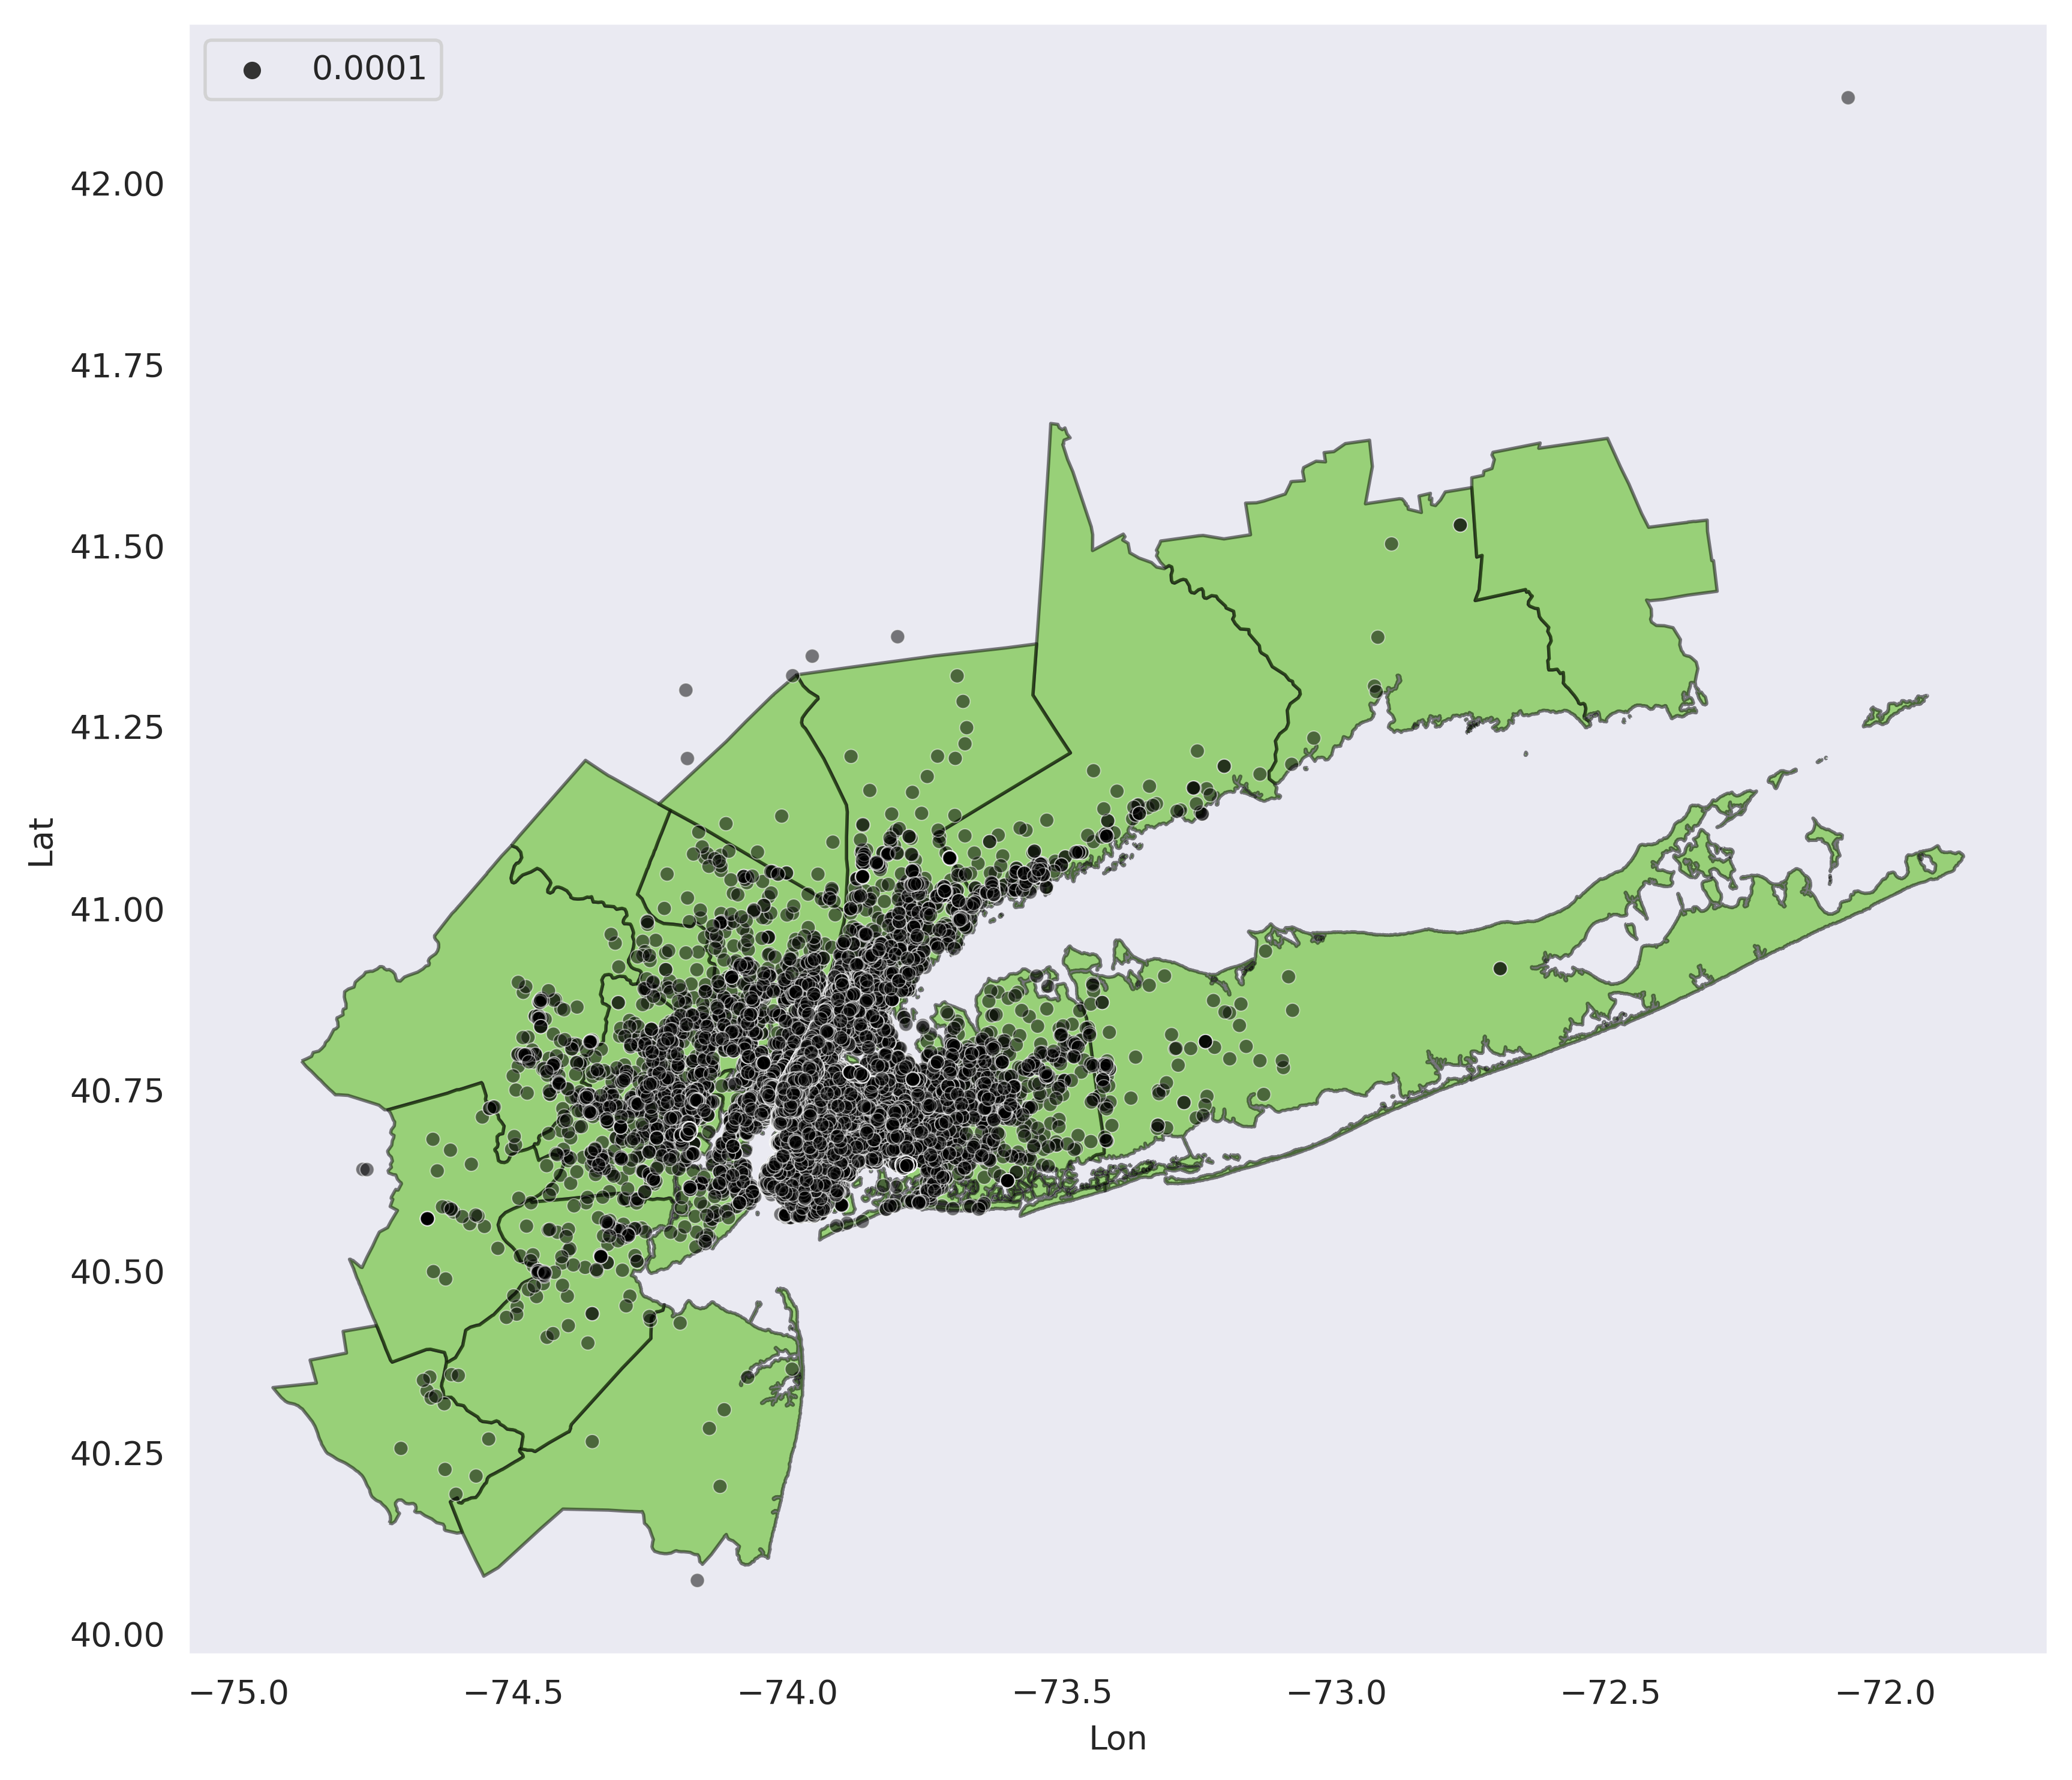

In [357]:
#plotting the geodata
#Each point represents where the customer was picked up
#This plot is only for april
matplotlib.rcParams['figure.dpi'] = 400

ax = final.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
sns.scatterplot(x = df1['Lon'], y = df1['Lat'], alpha = 0.5, size = 0.0001, color = 'black')